# Puzzle Piece Feature Extraction and Matching - Test Notebook
This notebook tests the functions for extracting geometric and color features from puzzle pieces, and matching sides using KNN.

In [23]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Import functions
from src.matching.feature_extraction import (
    _load_piece,
    _harris_corners_from_mask,
    _extract_largest_contour,
    _get_best_fitting_rect_coords,
    _extract_corners,
    _extract_sides,
    _extract_side_colors,
    _extract_geom_features,
    _extract_color_features,
    _classify_side,
    extract_features
)
from src.matching.side_matching import (
    match_sides_with_knn,
    get_valid_matches,
    run_side_matching
)

## Configuration

In [2]:
# Set paths
IMG_DIR = "../data/images"

# Get list of test images
image_dir = Path(IMG_DIR)
test_images = sorted(list(image_dir.glob("*.jpg")))[:5]  # Test first 5 pieces
print(f"Found {len(test_images)} test images")

Found 5 test images


## Test 1: Load Piece

Piece ID: IMG_20200328_131658
Image shape: (1280, 960, 3)
Mask shape: (1280, 960)


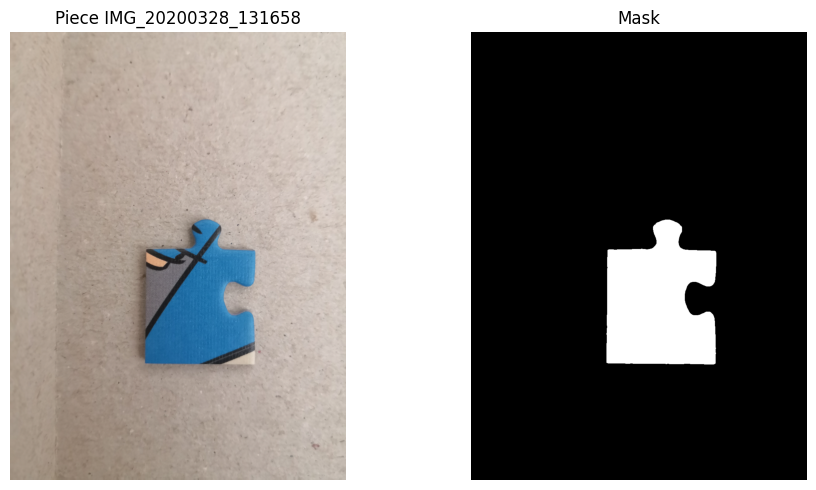

In [5]:
piece_id = test_images[0].stem
img_rgb, mask = _load_piece(piece_id)

print(f"Piece ID: {piece_id}")
print(f"Image shape: {img_rgb.shape}")
print(f"Mask shape: {mask.shape}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_rgb)
axes[0].set_title(f"Piece {piece_id}")
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Mask")
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Test 2: Extract Contour

Contour shape: (1520, 2)
Number of contour points: 1520


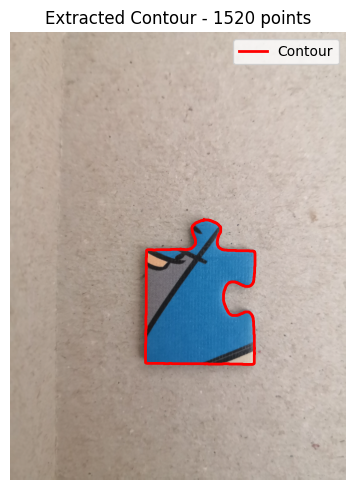

In [6]:
contour = _extract_largest_contour(mask)
print(f"Contour shape: {contour.shape}")
print(f"Number of contour points: {len(contour)}")

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img_rgb)
ax.plot(contour[:, 0], contour[:, 1], 'r-', linewidth=2, label='Contour')
ax.set_title(f"Extracted Contour - {len(contour)} points")
ax.legend()
ax.axis('off')
plt.tight_layout()
plt.show()

## Test 3: Detect Corners

Harris corners detected: 4
Final corners selected: 4


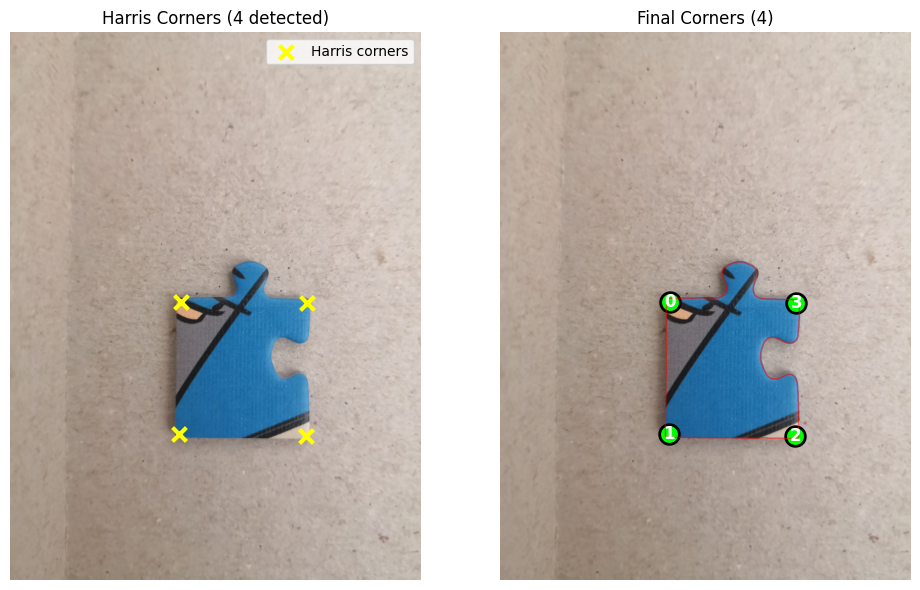

In [8]:
# Harris corners
harris_corners = _harris_corners_from_mask(mask)
print(f"Harris corners detected: {len(harris_corners)}")

# Extract best rectangle corners
corners = _extract_corners(mask, contour)
print(f"Final corners selected: {len(corners)}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Harris corners
axes[0].imshow(img_rgb)
if len(harris_corners) > 0:
    axes[0].scatter(harris_corners[:, 0], harris_corners[:, 1], 
                   c='yellow', s=100, marker='x', linewidths=3, label='Harris corners')
axes[0].set_title(f"Harris Corners ({len(harris_corners)} detected)")
axes[0].legend()
axes[0].axis('off')

# Final corners
axes[1].imshow(img_rgb)
axes[1].plot(contour[:, 0], contour[:, 1], 'r-', linewidth=1, alpha=0.5)
if len(corners) > 0:
    axes[1].scatter(corners[:, 0], corners[:, 1], 
                   c='lime', s=200, marker='o', edgecolors='black', linewidths=2)
    for i, corner in enumerate(corners):
        axes[1].text(corner[0], corner[1], str(i), fontsize=12, 
                    color='white', ha='center', va='center', weight='bold')
axes[1].set_title(f"Final Corners ({len(corners)})")
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Test 4: Extract Sides

Number of sides: 4
  Side 0: 450 points
  Side 1: 300 points
  Side 2: 324 points
  Side 3: 450 points


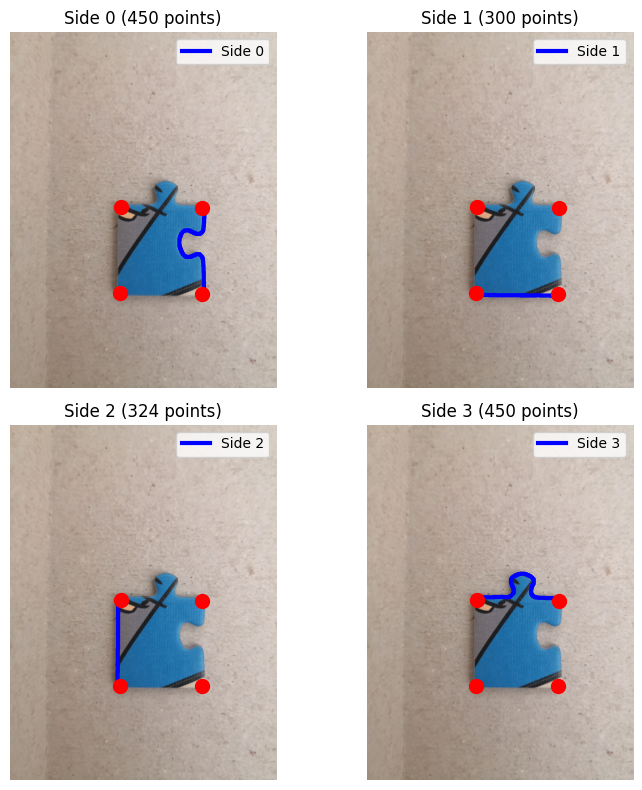

In [18]:
sides = _extract_sides(contour, corners)
print(f"Number of sides: {len(sides)}")
for i, side in enumerate(sides):
    print(f"  Side {i}: {len(side)} points")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for i, side in enumerate(sides):
    axes[i].imshow(img_rgb)
    axes[i].plot(contour[:, 0], contour[:, 1], 'gray', linewidth=1, alpha=0.3)
    axes[i].plot(side[:, 0], side[:, 1], 'b-', linewidth=3, label=f'Side {i}')
    axes[i].scatter(corners[:, 0], corners[:, 1], c='red', s=100, zorder=5)
    axes[i].set_title(f"Side {i} ({len(side)} points)")
    axes[i].legend()
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Test 5: Extract Side Colors

Extracted colors for side 0
Colors shape: (450, 3)
Color range: [33.0, 229.0]


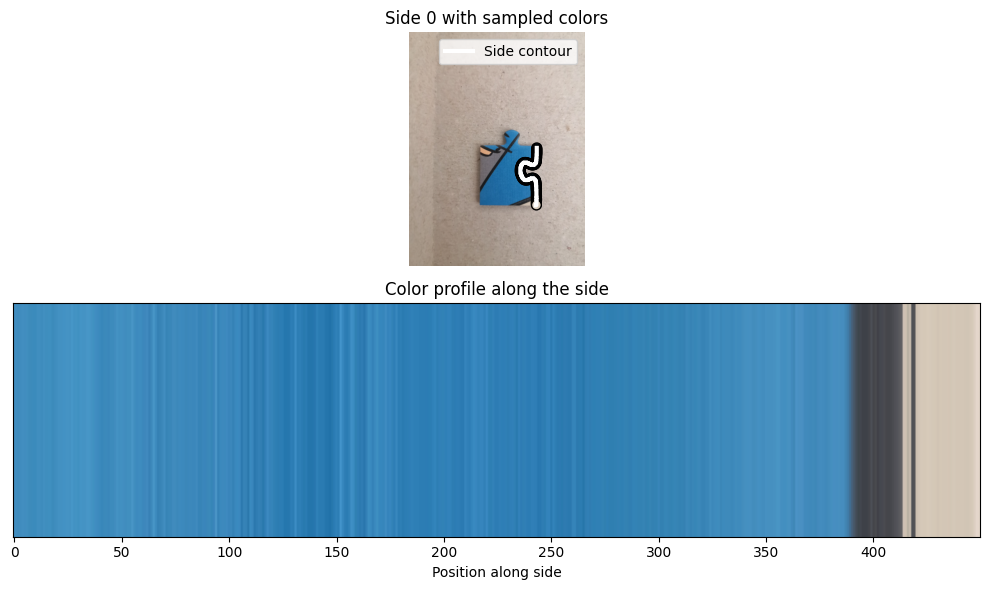

In [14]:
side_idx = 0
side = sides[side_idx]
colors = _extract_side_colors(side, img_rgb, mask, offset_inward=15)

print(f"Extracted colors for side {side_idx}")
print(f"Colors shape: {colors.shape}")
print(f"Color range: [{colors.min():.1f}, {colors.max():.1f}]")

# Visualize colors along the side
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Show side on image
axes[0].imshow(img_rgb)
axes[0].plot(side[:, 0], side[:, 1], 'w-', linewidth=3, label='Side contour')
axes[0].scatter(side[::5, 0], side[::5, 1], c=colors[::5]/255.0, s=50, edgecolors='black')
axes[0].set_title(f"Side {side_idx} with sampled colors")
axes[0].legend()
axes[0].axis('off')

# Show color profile
axes[1].imshow([colors/255.0], aspect='auto')
axes[1].set_title("Color profile along the side")
axes[1].set_xlabel("Position along side")
axes[1].set_yticks([])
plt.tight_layout()
plt.show()

## Test 6: Extract Geometric Features

Normalized side shape: (100, 2)
Side was reversed: False
Side classified as: sunken


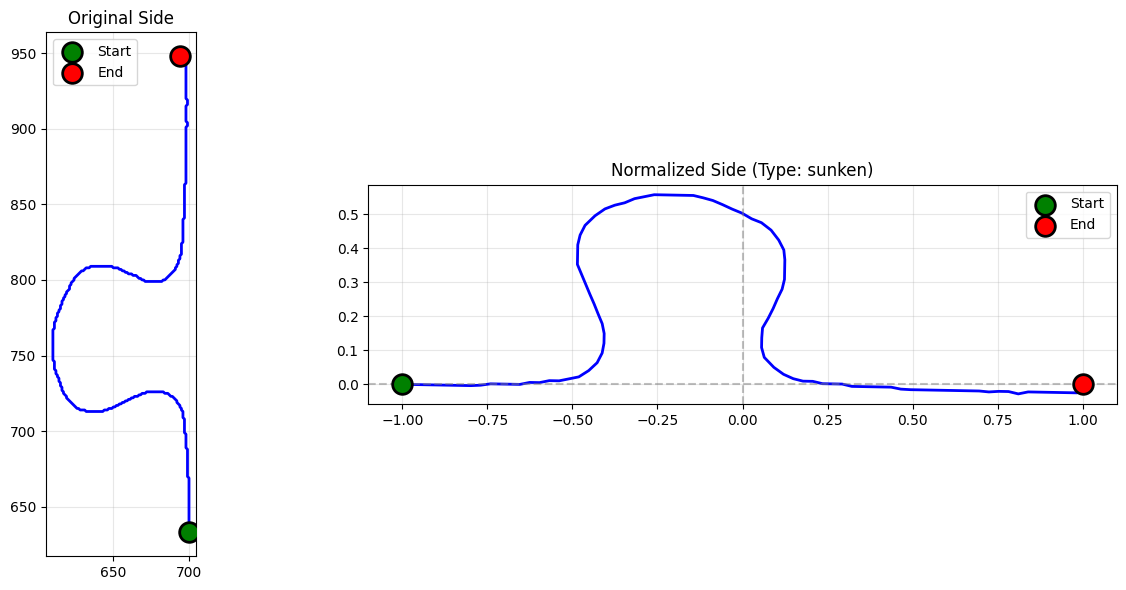

In [12]:
normalized_side, was_reversed = _extract_geom_features(side, num_points=100)
side_type = _classify_side(normalized_side)

print(f"Normalized side shape: {normalized_side.shape}")
print(f"Side was reversed: {was_reversed}")
print(f"Side classified as: {side_type}")

# Visualize normalization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original side
axes[0].plot(side[:, 0], side[:, 1], 'b-', linewidth=2)
axes[0].scatter(side[0, 0], side[0, 1], c='green', s=200, marker='o', 
               edgecolors='black', linewidths=2, label='Start', zorder=5)
axes[0].scatter(side[-1, 0], side[-1, 1], c='red', s=200, marker='o', 
               edgecolors='black', linewidths=2, label='End', zorder=5)
axes[0].set_aspect('equal')
axes[0].set_title("Original Side")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Normalized side
axes[1].plot(normalized_side[:, 0], normalized_side[:, 1], 'b-', linewidth=2)
axes[1].scatter(normalized_side[0, 0], normalized_side[0, 1], c='green', s=200, 
               marker='o', edgecolors='black', linewidths=2, label='Start', zorder=5)
axes[1].scatter(normalized_side[-1, 0], normalized_side[-1, 1], c='red', s=200, 
               marker='o', edgecolors='black', linewidths=2, label='End', zorder=5)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_aspect('equal')
axes[1].set_title(f"Normalized Side (Type: {side_type})")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Test 7: Extract Color Features

Color features shape: (100, 9)
Features per point: 9
Feature composition: 3 (z-score RGB) + 3 (normalized RGB) + 3 (normalized HSV) = 9


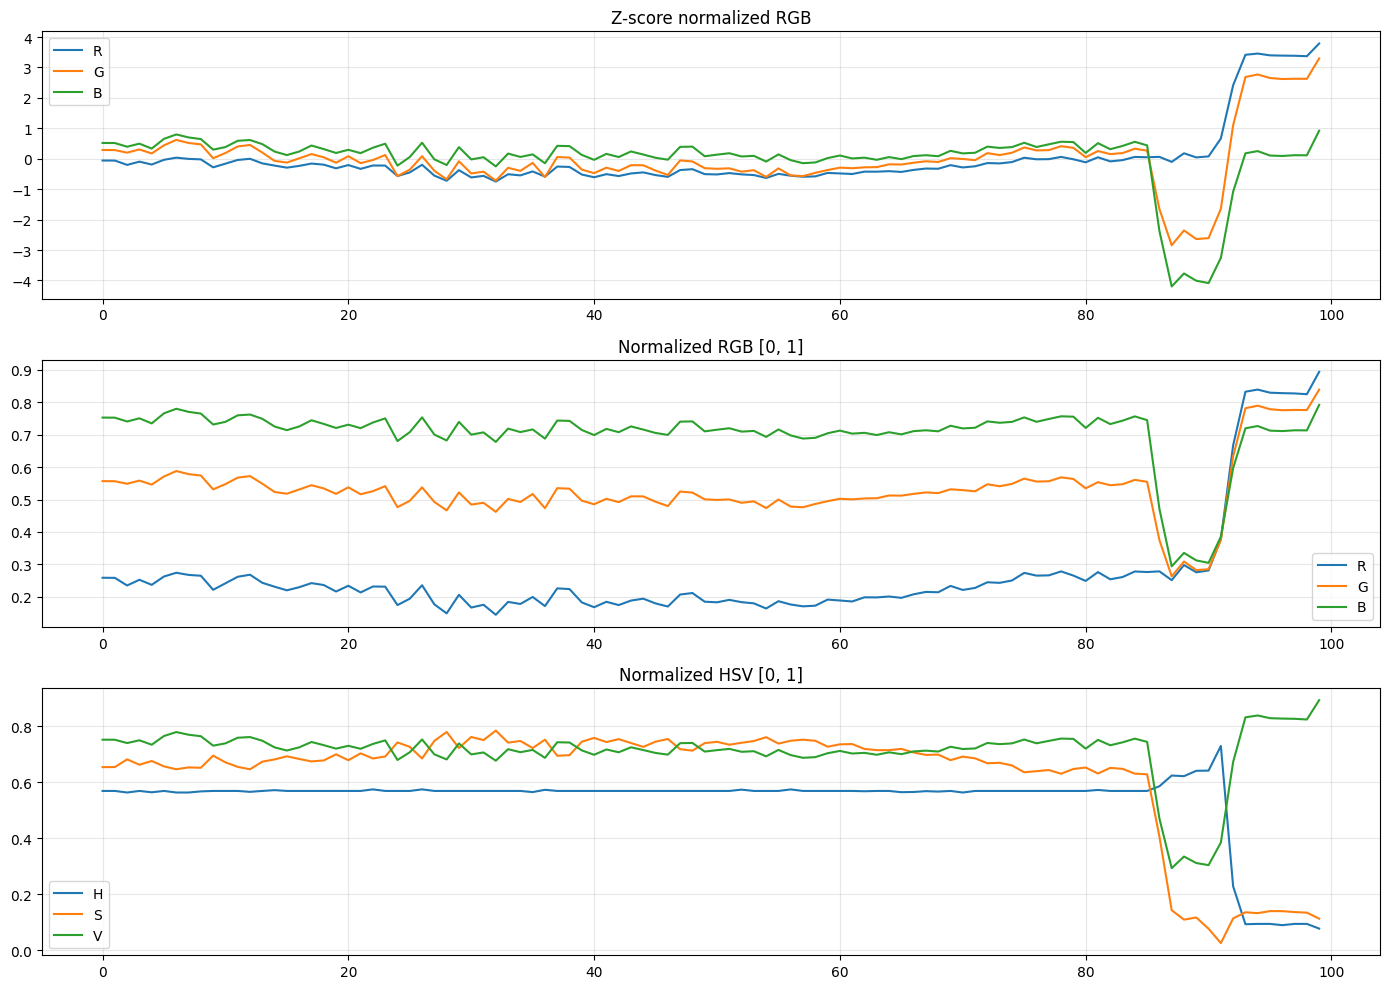

In [16]:
color_features = _extract_color_features(colors, num_points=100)

print(f"Color features shape: {color_features.shape}")
print(f"Features per point: {color_features.shape[1]}")
print("Feature composition: 3 (z-score RGB) + 3 (normalized RGB) + 3 (normalized HSV) = 9")

# Visualize color features
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Z-score RGB
axes[0].plot(color_features[:, 0:3])
axes[0].set_title("Z-score normalized RGB")
axes[0].legend(['R', 'G', 'B'])
axes[0].grid(True, alpha=0.3)

# Normalized RGB
axes[1].plot(color_features[:, 3:6])
axes[1].set_title("Normalized RGB [0, 1]")
axes[1].legend(['R', 'G', 'B'])
axes[1].grid(True, alpha=0.3)

# Normalized HSV
axes[2].plot(color_features[:, 6:9])
axes[2].set_title("Normalized HSV [0, 1]")
axes[2].legend(['H', 'S', 'V'])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Test 8: Extract Features from Multiple Pieces

In [19]:
geom_features, color_features, side_indices = extract_features(test_images)

print(f"\nResults:")
print(f"Geometric features shape: {geom_features.shape}")
print(f"Color features shape: {color_features.shape}")
print(f"Side indices shape: {side_indices.shape}")
print(f"\nTotal non-flat sides extracted: {len(side_indices)}")

# Show distribution of sides per piece
unique_pieces, counts = np.unique(side_indices[:, 0], return_counts=True)
print(f"\nSides per piece:")
for piece_idx, count in zip(unique_pieces, counts):
    print(f"  Piece {piece_idx} ({test_images[piece_idx].stem}): {count} non-flat sides")

Extracting features from 5 puzzle pieces...

Extracted 14 non-flat sides from 5 puzzle pieces

Results:
Geometric features shape: (14, 100, 2)
Color features shape: (14, 100, 9)
Side indices shape: (14, 2)

Total non-flat sides extracted: 14

Sides per piece:
  Piece 0 (IMG_20200328_131658): 2 non-flat sides
  Piece 1 (IMG_20200328_131710): 3 non-flat sides
  Piece 2 (IMG_20200328_131720): 3 non-flat sides
  Piece 3 (IMG_20200328_131729): 3 non-flat sides
  Piece 4 (IMG_20200328_131738): 3 non-flat sides


## Test 9: KNN Side Matching

In [ ]:
all_images = sorted(list(image_dir.glob("*.jpg")))
geom_features, color_features, side_indices = extract_features(all_images)

# Check feature shapes before matching
print("Feature shapes before matching:")
print(f"  Geom features: {geom_features.shape}")
print(f"  Color features: {color_features.shape}")

# Check flattened features
geom_flat = geom_features.reshape(geom_features.shape[0], -1)
color_flat = color_features.reshape(color_features.shape[0], -1)
combined = np.concatenate([geom_flat, color_flat], axis=1)

print(f"\nFlattened dimensions:")
print(f"  Geom flat: {geom_flat.shape}")
print(f"  Color flat: {color_flat.shape}")
print(f"  Combined: {combined.shape}")

# Check if scaling is applied
scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined)

print(f"\nBefore scaling:")
print(f"  Mean: {combined.mean():.4f}, Std: {combined.std():.4f}")
print(f"After scaling:")
print(f"  Mean: {combined_scaled.mean():.4f}, Std: {combined_scaled.std():.4f}")

# Test distance on scaled features
from scipy.spatial.distance import euclidean
test_dist = euclidean(combined_scaled[0], combined_scaled[1])
print(f"\nSample distance between sides 0 and 1: {test_dist:.4f}")

# Perform matching
distances, indices = match_sides_with_knn(
    geom_features, 
    color_features, 
    n_neighbors=3,  # Get top 3 matches
    scale=True
)

print(f"Distances shape: {distances.shape}")
print(f"Indices shape: {indices.shape}")
print(f"\nDistance statistics:")
print(f"  Min distance: {distances.min():.4f}")
print(f"  Max distance: {distances.max():.4f}")
print(f"  Mean distance: {distances.mean():.4f}")
print(f"  Median distance: {np.median(distances):.4f}")

# Visualize distance distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of nearest neighbor distances
axes[0].hist(distances[:, 0], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Distance to nearest neighbor")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Nearest Neighbor Distances")
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# All k neighbors
for k in range(distances.shape[1]):
    axes[1].hist(distances[:, k], bins=50, alpha=0.5, label=f'Neighbor {k+1}')
axes[1].set_xlabel("Distance")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distance Distribution for All k Neighbors")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Extracting features from 1000 puzzle pieces...


## Test 10: Valid Matches Filtering

Threshold 0.3: 0 valid matches
Threshold 0.5: 0 valid matches
Threshold 0.7: 0 valid matches
Threshold 1.0: 0 valid matches

First 10 matches (threshold=0.5):


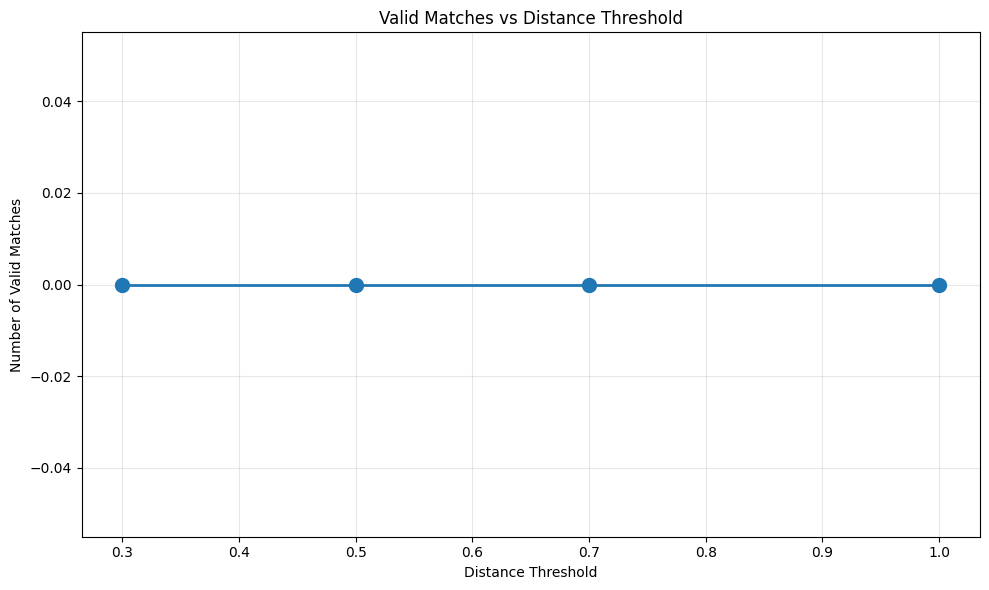

In [30]:
# Get valid matches with different thresholds
thresholds = [0.3, 0.5, 0.7, 1.0]
valid_matches_by_threshold = {}

for thresh in thresholds:
    valid_matches = get_valid_matches(distances, indices, side_indices, max_distance=thresh)
    valid_matches_by_threshold[thresh] = valid_matches
    print(f"Threshold {thresh:.1f}: {len(valid_matches)} valid matches")

# Use default threshold for detailed analysis
default_threshold = 0.5
valid_matches = valid_matches_by_threshold[default_threshold]

# Show some example matches
print(f"\nFirst 10 matches (threshold={default_threshold}):")
for i, match in enumerate(valid_matches[:10]):
    print(f"  {i+1}. Piece {match['query_piece']} side {match['query_side']} → "
          f"Piece {match['match_piece']} side {match['match_side']} "
          f"(distance: {match['distance']:.4f})")

# Plot threshold sensitivity
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
match_counts = [len(valid_matches_by_threshold[t]) for t in thresholds]
ax.plot(thresholds, match_counts, 'o-', linewidth=2, markersize=10)
ax.set_xlabel("Distance Threshold")
ax.set_ylabel("Number of Valid Matches")
ax.set_title("Valid Matches vs Distance Threshold")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Test 11: Run Full Matching Pipeline

In [31]:
valid_matches = run_side_matching(
    geom_features, 
    color_features, 
    side_indices,
    n_neighbors=1,
    max_distance=0.5,
    scale=True
)

# Analyze match distribution
match_by_piece = {}
for match in valid_matches:
    q_piece = match['query_piece']
    m_piece = match['match_piece']
    
    if q_piece not in match_by_piece:
        match_by_piece[q_piece] = []
    match_by_piece[q_piece].append(m_piece)

print(f"\nMatches per piece:")
for piece_idx in sorted(match_by_piece.keys()):
    matches = match_by_piece[piece_idx]
    unique_matches = len(set(matches))
    print(f"  Piece {piece_idx} ({test_images[piece_idx].stem}): "
          f"{len(matches)} matches with {unique_matches} unique pieces")

Matching 3870 sides using KNN...
Found 0 valid matches.

Matches per piece:


## Test 12: Visualize Side Matches

In [27]:
# Pick a few good matches to visualize
num_viz = min(4, len(valid_matches))
viz_matches = valid_matches[:num_viz]

fig, axes = plt.subplots(num_viz, 2, figsize=(12, 4*num_viz))
if num_viz == 1:
    axes = axes.reshape(1, -1)

for idx, match in enumerate(viz_matches):
    query_piece_idx = match['query_piece']
    query_side_idx = match['query_side']
    match_piece_idx = match['match_piece']
    match_side_idx = match['match_side']
    distance = match['distance']
    
    # Load both pieces
    query_img, query_mask = _load_piece(test_images[query_piece_idx].stem)
    match_img, match_mask = _load_piece(test_images[match_piece_idx].stem)
    
    # Extract sides
    query_contour = _extract_largest_contour(query_mask)
    query_corners = _extract_corners(query_mask, query_contour)
    query_sides = _extract_sides(query_contour, query_corners)
    
    match_contour = _extract_largest_contour(match_mask)
    match_corners = _extract_corners(match_mask, match_contour)
    match_sides = _extract_sides(match_contour, match_corners)
    
    # Query piece
    axes[idx, 0].imshow(query_img)
    axes[idx, 0].plot(query_contour[:, 0], query_contour[:, 1], 'gray', linewidth=1, alpha=0.3)
    if query_side_idx < len(query_sides):
        query_side = query_sides[query_side_idx]
        axes[idx, 0].plot(query_side[:, 0], query_side[:, 1], 'lime', linewidth=3)
    axes[idx, 0].set_title(f"Query: Piece {query_piece_idx}, Side {query_side_idx}")
    axes[idx, 0].axis('off')
    
    # Match piece
    axes[idx, 1].imshow(match_img)
    axes[idx, 1].plot(match_contour[:, 0], match_contour[:, 1], 'gray', linewidth=1, alpha=0.3)
    if match_side_idx < len(match_sides):
        match_side = match_sides[match_side_idx]
        axes[idx, 1].plot(match_side[:, 0], match_side[:, 1], 'cyan', linewidth=3)
    axes[idx, 1].set_title(f"Match: Piece {match_piece_idx}, Side {match_side_idx}\nDistance: {distance:.4f}")
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1200x0 with 0 Axes>

## Test 13: Rotation and Reversal Check

In [ ]:
# Take a sample side and show its transformation
sample_idx = 0
sample_geom = geom_features[sample_idx:sample_idx+1]

# Apply the transformation manually
rotated_side = (sample_geom * (-1, -1))[:, ::-1, :]

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original
axes[0].plot(sample_geom[0, :, 0], sample_geom[0, :, 1], 'b-', linewidth=2)
axes[0].scatter(sample_geom[0, 0, 0], sample_geom[0, 0, 1], c='green', s=200, 
               marker='o', label='Start', zorder=5)
axes[0].scatter(sample_geom[0, -1, 0], sample_geom[0, -1, 1], c='red', s=200, 
               marker='o', label='End', zorder=5)
axes[0].set_aspect('equal')
axes[0].set_title("Original Side")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rotated/Reversed
axes[1].plot(rotated_side[0, :, 0], rotated_side[0, :, 1], 'r-', linewidth=2)
axes[1].scatter(rotated_side[0, 0, 0], rotated_side[0, 0, 1], c='green', s=200, 
               marker='o', label='Start', zorder=5)
axes[1].scatter(rotated_side[0, -1, 0], rotated_side[0, -1, 1], c='red', s=200, 
               marker='o', label='End', zorder=5)
axes[1].set_aspect('equal')
axes[1].set_title("Rotated 180° + Reversed")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nThis transformation allows matching sides that are rotated 180° relative to each other,")
print("which is how puzzle pieces with complementary tabs and blanks would align.")

## Summary

In [ ]:
print(f"\n✓ Successfully loaded {len(test_images)} puzzle pieces")
print(f"✓ Extracted contours, corners, and sides")
print(f"✓ Generated {len(geom_features)} geometric feature vectors")
print(f"✓ Generated {len(color_features)} color feature vectors")
print(f"✓ Performed KNN matching with {len(valid_matches)} valid matches")
print(f"\nGeometric features: {geom_features.shape[1]} points × {geom_features.shape[2]} dimensions")
print(f"Color features: {color_features.shape[1]} points × {color_features.shape[2]} channels")
print(f"Match rate: {len(valid_matches) / len(geom_features) * 100:.1f}% of sides have valid matches")
print("\nAll tests completed successfully!")